# Example detection of Venus echo

Thomas Telkamp, 30-03-2025, CC BY-SA 4.0

The data is licensed under a Creative Commons Attribution 4.0 International License (CC BY 4.0), author of the Dwingeloo files is Stichting Radiotelescoop Dwingeloo, and author of the Stockert files is Astropeiler Stockert e.V.

In [1]:
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.dates import num2date
from matplotlib.ticker import FuncFormatter

import numpy as np
import pandas as pd

import sigmf

import astropy.units as u
from astropy.time import Time
import astropy.constants

In [2]:
def doppler(v, f):
    return (1 - v / astropy.constants.c.value) * f

In [3]:
# IQ files

# Note: the current released of the sigmf module (1.2.8) fails to open these SigMF files, use 
# an older version as workaround (e.g. with "pip install sigmf==1.2.6") until this is fixed

path = "/home/www/venus/"

# Dwingeloo, cw1
# pol1 = path+"/5ksps/dwingeloo_eve_extract_2025_03_22_12_05_39_1299.500MHz_5ksps_ci16_le.sigmf-meta"

# Stockert, cw2
pol1 = (
    path
    + "/5ksps/stockert_eve_extract_2025_03_22_12_15_39_1299.500MHz_5ksps_ci16_le.chan0.sigmf-meta"
)
pol2 = (
    path
    + "/5ksps/stockert_eve_extract_2025_03_22_12_15_39_1299.500MHz_5ksps_ci16_le.chan1.sigmf-meta"
)

if "dwingeloo" in pol1:
    site = "Dwingeloo"
elif "stockert" in pol1:
    site = "Stockert"
else:
    site = ""

handle = sigmf.sigmffile.fromfile(pol1)
data = handle.read_samples()

if site == "Stockert":

    handle2 = sigmf.sigmffile.fromfile(pol2)

    data2 = handle2.read_samples()

    pow_1 = np.mean(np.abs(data))
    pow_2 = np.mean(np.abs(data2))

    data2 = data2 * (pow_1 / pow_2)

    # Combine to LHCP
    data = data + np.exp(1j * 260 * np.pi / 180) * data2

sample_rate = int(handle.get_global_info()[handle.SAMPLE_RATE_KEY])
center_freq = handle.get_capture_info(0)["core:frequency"]
start_time = handle.get_capture_info(0)["core:datetime"]

fs = sample_rate

print("Site:", site)
print("Sample rate:", sample_rate, "sps")
print("Center frequency:", center_freq, "Hz")
print("Start time:", start_time)
print("Duration:", len(data) / fs, "sec")

Site: Stockert
Sample rate: 5000 sps
Center frequency: 1299500000 Hz
Start time: 2025-03-22T12:15:39.000000
Duration: 280.0 sec


In [4]:
if site == "Dwingeloo":
    doppler_file = path + "dwingeloo_venus_doppler.csv"
else:
    doppler_file = path + "stockert_venus_doppler.csv"

doppler_data = pd.read_csv(doppler_file, sep=",")

doppler_timestamps = Time(list(doppler_data["rx_time_utc"]))
freq_offset = np.array(list(doppler_data["freq_offset_hz"]))
doppler_rate = np.array(list(doppler_data["doppler_rate_hz_s"]))

In [5]:
time_astropy = Time(start_time)
time_astropy

<Time object: scale='utc' format='isot' value=2025-03-22T12:15:39.000>

In [6]:
# find start_time in Doppler data
duration = int(len(data) / sample_rate)
start_index = np.argmin(np.abs(doppler_timestamps - time_astropy))
freq_offset = freq_offset[start_index : start_index + duration]
doppler_rate = doppler_rate[start_index : start_index + duration]

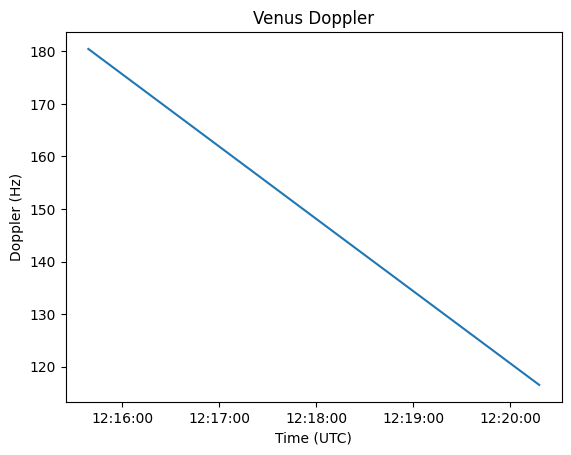

In [7]:
time_range = time_astropy + np.arange(len(freq_offset)) * u.s

fig, ax = plt.subplots()
ax.plot(time_range.datetime, (freq_offset), "-")
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Doppler (Hz)")
ax.xaxis_date()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{num2date(x):%H:%M:%S}"))
ax.set_title("Venus Doppler");

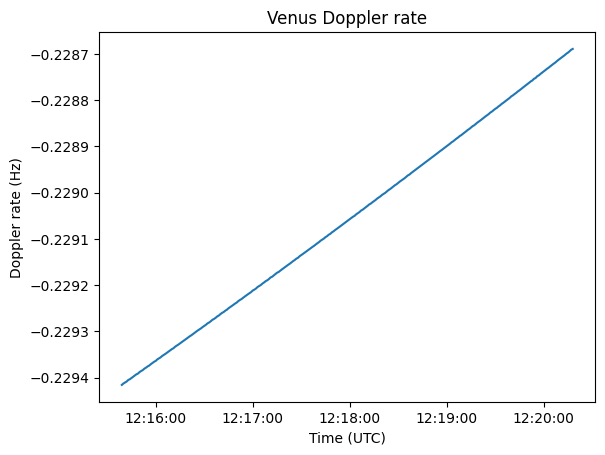

In [8]:
time_range = time_astropy + np.arange(len(doppler_rate)) * u.s

fig, ax = plt.subplots()
ax.plot(time_range.datetime, doppler_rate, "-")
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Doppler rate (Hz)")
ax.xaxis_date()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{num2date(x):%H:%M:%S}"))
ax.set_title("Venus Doppler rate");

In [9]:
expected_freq_offset = freq_offset[0]
print(f"Expected Doppler offset: {expected_freq_offset:.3f} Hz")

Expected Doppler offset: 180.436 Hz


In [10]:
# Compensate for Doppler and Doppler rate

dr = np.repeat(doppler_rate, len(data) / len(doppler_rate))
t_s = np.arange(len(data)) / fs
fdrift = -dr # Doppler rate
f0_Hz = -expected_freq_offset # Doppler
phi_Hz = (fdrift * t_s**2) / 2 + (f0_Hz * t_s)  # Instantaneous phase.
phi_rad = 2 * np.pi * phi_Hz  # Convert to radians.
data = data * np.exp(1j * phi_rad)

In [11]:
freq = np.fft.fftshift(np.fft.fftfreq(sample_rate, d=1 / sample_rate))

In [12]:
spectrum = np.fft.fftshift(np.fft.fft(data.reshape(-1, int(sample_rate))))
spectrum.shape

(280, 5000)

In [13]:
spec_sum = np.mean(np.abs(spectrum), axis=0)

In [14]:
subset = range(int(len(spec_sum) / 2 - 200), int(len(spec_sum) / 2 + 200))

In [15]:
plot_cw = spec_sum[subset] / np.median(spec_sum[subset])
plot_cw = plot_cw**2

stddev = np.std(plot_cw)
s4 = 4 * stddev
s_med = np.median(plot_cw)
s_max = np.max(plot_cw)

In [16]:
mid_samp = plot_cw[int(len(plot_cw) / 2)]
detect_sigma = np.round((mid_samp - 1) / stddev, 2)
print(detect_sigma)

6.02


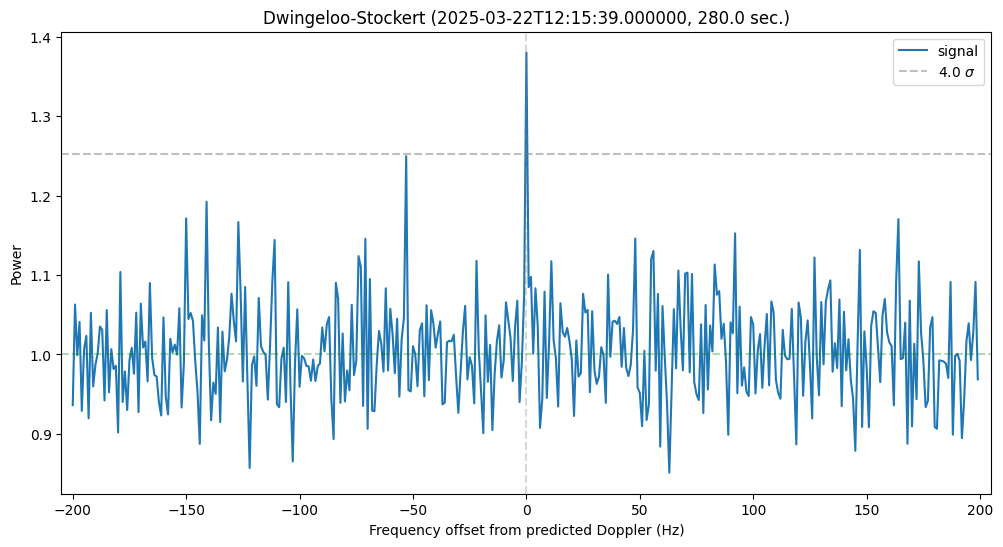

In [17]:
fig, ax0 = plt.subplots(figsize=(12, 6))
ax0.plot(freq[subset], plot_cw, "-", label="signal")
ax0.set_xlim(-205, 205)
ax0.axvline(0, linestyle="--", color="grey", alpha=0.3)
ax0.axhline(s_med, linestyle="--", color="green", alpha=0.3)
ax0.axhline(1 + s4, linestyle="--", color="grey", alpha=0.5, label="4.0 $\sigma$")
ax0.set_xlabel("Frequency offset from predicted Doppler (Hz)")
ax0.set_ylabel("Power")
ax0.set_title(
    "Dwingeloo-" + site + " (" + str(start_time) + ", " + str(len(data) / fs) + " sec.)"
)
ax0.legend();

In [18]:
overlap = 8
fft_size = int(sample_rate)
pfb_size = fft_size * overlap
# pfb_buffer = np.zeros(pfb_size)+0*1j
blocks = len(data) // (fft_size)
blocks

280

In [19]:
# Blackman-Harris

a0 = 0.35875
a1 = 0.48829
a2 = 0.14128
a3 = 0.01168

taps = np.zeros(pfb_size)
blackman_window = np.zeros(pfb_size)

i = np.arange(pfb_size)
j = i - (pfb_size) / 2
taps = np.sinc((overlap) * (j / (pfb_size)))
blackman_window = (
    a0
    - a1 * np.cos(2 * np.pi * i / (pfb_size - 1))
    + a2 * np.cos(4 * np.pi * i / (pfb_size - 1))
    + a3 * np.cos(6 * np.pi * i / (pfb_size - 1))
)
blackman_window = blackman_window * taps

In [20]:
spectrum = np.zeros((blocks, fft_size), dtype=np.complex128)

for i in range(blocks):
    start_index = i - (overlap - 1)
    if start_index < 0:
        start_index = 0
    l = ((i + 1) - start_index) * fft_size
    pfb_buffer = np.zeros(pfb_size, dtype=np.complex128)
    pfb_buffer[-l:] = data[start_index * fft_size : (i + 1) * fft_size]
    fft_input = np.mean(((pfb_buffer * blackman_window).reshape(overlap, -1)), axis=0)
    spectrum[i, :] = np.fft.fftshift(np.fft.fft(fft_input))

In [21]:
spec_sum = np.mean(np.abs(spectrum), axis=0)

In [22]:
subset = range(int(len(spec_sum) / 2 - 200), int(len(spec_sum) / 2 + 200))
freq = np.fft.fftshift(np.fft.fftfreq(fft_size, d=1 / fft_size))

In [23]:
plot_cw = spec_sum[subset] / np.median(spec_sum[subset])

plot_cw = plot_cw**2

plot_noise = plot_cw.copy()
plot_noise[int(len(plot_cw) / 2)] = np.nan

stddev = np.nanstd(plot_noise)
s4 = 4 * stddev
s_med = np.nanmedian(plot_noise)
s_max = plot_cw[int(len(plot_cw) / 2)]
print("Peak:", np.round(10*np.log10(s_max),2), "dB")

Peak: 1.41 dB


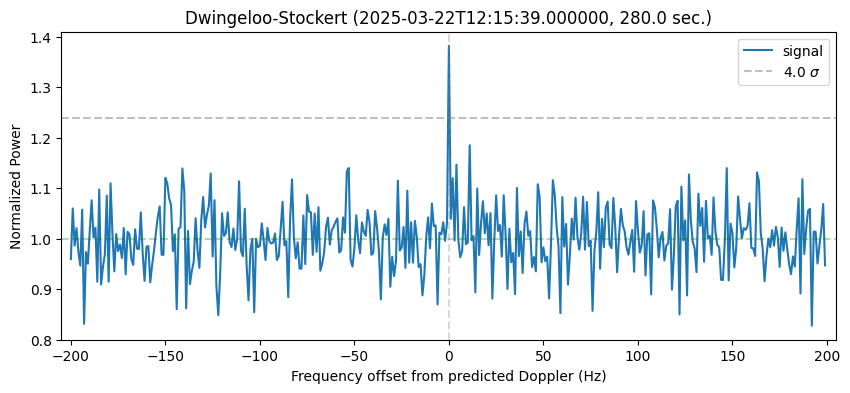

In [24]:
fig, ax0 = plt.subplots(figsize=(10, 4))
ax0.plot(freq[subset], plot_cw, "-", label="signal")
ax0.set_xlim(-205, 205)
ax0.axvline(0, linestyle="--", color="grey", alpha=0.3)
ax0.axhline(s_med, linestyle="--", color="green", alpha=0.3)
ax0.axhline(1 + s4, linestyle="--", color="grey", alpha=0.5, label="4.0 $\sigma$")
ax0.set_xlabel("Frequency offset from predicted Doppler (Hz)")
ax0.set_ylabel("Normalized Power")
ax0.set_title(
    "Dwingeloo-" + site + " (" + str(start_time) + ", " + str(len(data) / fs) + " sec.)"
)
ax0.legend();

In [25]:
mid_samp = plot_cw[int(len(plot_cw) / 2)]
detect_sigma = np.round((mid_samp - 1) / stddev, 2)
print("Detection:", detect_sigma, "sigma")

Detection: 6.37 sigma
